In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import plotly.express as px
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster, metrics
from all_functions import refactorGiniWorldBankDf
from sklearn.metrics import pairwise_distances_argmin_min


In [2]:
revenuMondial = pd.read_csv("../data/data-projet7.csv", parse_dates=True)
display(revenuMondial.head())
display(revenuMondial.shape)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


(11599, 6)

In [3]:
print(len(revenuMondial) - len(revenuMondial.drop_duplicates()), 'doublon') # Aucun doublon

0 doublon


In [4]:
# Ci-dessus, les revenues mondiale pour une période donnée

In [5]:
# Premère étape. Identifiquation des pays

In [6]:
countryCodes = pd.read_csv("../data/iso.csv", parse_dates=True)
countryCodes.head(5)

,name,iso
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Andorra,AND
4,Angola,AGO


In [7]:
merged_df = pd.merge(revenuMondial, countryCodes, left_on='country', right_on='iso', how='left')
# On veux obtenir le nom des pays via leurs code iso.
incomes = merged_df[['name','country', 'year_survey', 'quantile','nb_quantiles','income','gdpppp']]
incomes = incomes.rename(columns={"name":"nation"})
incomes = incomes.rename(columns={"year_survey":"year"})
# On transforme en float 
incomes.replace(',', '.', regex=True, inplace=True)
incomes['income'] = incomes['income'].astype(float)
incomes['gdpppp'] = incomes['gdpppp'].astype(float)
incomes['year'] = incomes['year'].astype(int)
incomes.head(5)

,nation,country,year,quantile,nb_quantiles,income,gdpppp
0,Albania,ALB,2008,1,100,728.89795,7297.0
1,Albania,ALB,2008,2,100,916.66235,7297.0
2,Albania,ALB,2008,3,100,1010.91600,7297.0
3,Albania,ALB,2008,4,100,1086.90780,7297.0
4,Albania,ALB,2008,5,100,1132.69970,7297.0


In [8]:
# Information dataFrame

In [9]:
incomes["year"] = incomes["year"].astype(int)
# Résumé des dates minimales et maximales
date_min = incomes['year'].min()
date_max = incomes['year'].max()
# Résumé des revenus minimales et maximales
incomeMin = incomes['income'].min()
incomeMax = incomes['income'].max()
# Affichage des résultats
print(f"Date minimale : {date_min}")
print(f"Date maximale : {date_max}")

Date minimale : 2004
Date maximale : 2011


In [10]:
firstQuantile = incomes[incomes['quantile'] == 1]
lowestFistQuantile = firstQuantile.sort_values(by='income')
hundredQuantile = incomes[incomes['quantile'] == 100]
highestFistQuantile = hundredQuantile.sort_values(by='income', ascending=False)
highestFistQuantile.iloc[0]

nation          United States
country                   USA
year                     2008
quantile                  100
nb_quantiles              100
income              176928.55
gdpppp                43261.0
Name: 11098, dtype: object

In [11]:
arrIncomesYears = incomes['year'].sort_values(ascending=True).unique()
arrIncomesYears = [str(value) for value in arrIncomesYears]
arrIncomesYears

['2004', '2006', '2007', '2008', '2009', '2010', '2011']

In [12]:
nombrePays = incomes['country'].nunique()
print(f"Nombre de pays par année: {nombrePays}")

Nombre de pays par année: 116


Traitement des donnée manquante

In [13]:
# Grouper par pays
groupedByCountry = incomes.groupby('country')
# Liste des quantiles attendus (1 à 100)
expectedQuantiles = set(range(1, 101))
# Créer une liste pour stocker les pays avec des quantiles manquants
countriesWithMissingQuantiles = []

# Parcourir chaque groupe (pays) et vérifier les quantiles manquants
for country, group in groupedByCountry:
    actualQuantiles = set(group['quantile'])
    missingQuantiles = expectedQuantiles - actualQuantiles
    
    if missingQuantiles:
        countriesWithMissingQuantiles.append((country, missingQuantiles))

# Afficher les résultats
if countriesWithMissingQuantiles:
    print("Pays avec des quantiles manquants :")
    for country, missingQuantiles in countriesWithMissingQuantiles:
        print(f"{country}: Quantiles manquants {missingQuantiles}")
else:
    print("Aucun pays avec des quantiles manquants.")

Pays avec des quantiles manquants :
LTU: Quantiles manquants {41}


In [14]:
ltu = 'LTU'
moyenneLTUIncome = incomes.loc[(incomes['country'] == ltu) & (incomes['quantile'] == 40) 
            | (incomes['country'] == ltu) & (incomes['quantile'] == 42)]['income'].mean();
moyenneLTUIncome

4882.14065

In [15]:
dfMissingRowLTU = pd.DataFrame({'nation':'Lithuania','country': [ltu], 'year': [2008], 'quantile': [41], 
                           'nb_quantiles': [100], 'income': [moyenneLTUIncome], 'gdpppp': 17571.0});

dfMissingRowLTU

,nation,country,year,quantile,nb_quantiles,income,gdpppp
0,Lithuania,LTU,2008,41,100,4882.14065,17571.0


In [16]:
incomes = pd.concat([incomes, dfMissingRowLTU], ignore_index=True, sort=True)
display(incomes.shape)
incomes.head()

(11700, 7)

,country,gdpppp,income,nation,nb_quantiles,quantile,year
0,ALB,7297.0,728.89795,Albania,100,1,2008
1,ALB,7297.0,916.66235,Albania,100,2,2008
2,ALB,7297.0,1010.91600,Albania,100,3,2008
3,ALB,7297.0,1086.90780,Albania,100,4,2008
4,ALB,7297.0,1132.69970,Albania,100,5,2008


In [17]:
incomes[incomes['country'] == 'LTU'].head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year
6200,LTU,17571.0,566.3453,Lithuania,100,1,2008


In [18]:
countriesNullsdpppp = incomes.loc[incomes['gdpppp'].isnull(), 'country'].unique()
countriesNullsdpppp

array(['XKX', 'PSE'], dtype=object)

In [19]:
xkx = countriesNullsdpppp[0];
pse = countriesNullsdpppp[1];

Je récupére le dataset de la worlbank afin de récuperer les gd pppp 


In [20]:
gdpppp = pd.read_csv("../data/worldbank-gdpppp.csv", parse_dates=True, sep=';')
gdpppp = gdpppp.iloc[: , :-1]
copyGd = gdpppp.copy
gdpppp.head(1)

,Country Name,Country Code,Indicator Name,1960,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,GDP per capita (constant LCU),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47461.615474,46386.672241,45804.246592,46317.795605,49316.830489,50242.212175,48863.866312,37095.214575,47369.425924,52368.693789


In [21]:
pseGd = gdpppp[gdpppp['Country Code'] == pse]
pseGdppp = pseGd['2009'].values[0]
pseGdppp

2840.01594969395

In [22]:
getXKXGd = gdpppp[gdpppp['Country Code'] == xkx]
xkxGdppp = getXKXGd['2009'].values[0]
xkxGdppp

2109.4339172761

In [23]:
incomes.loc[incomes['country'] == xkx, 'gdpppp'] = xkxGdppp
incomes.loc[incomes['country'] == xkx, 'nation'] = 'Kosovo'
incomes.loc[incomes['country'] == pse, 'gdpppp'] = pseGdppp
incomes.loc[incomes['country'] == pse, 'nation'] = 'Palestine'
incomes[incomes['country'] == xkx].head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year
5800,XKX,2109.433917,437.8937,Kosovo,100,1,2008


In [24]:
incomes[incomes['country'] == pse].head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year
11299,PSE,2840.01595,195.2899,Palestine,100,1,2009


In [25]:
incomes.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year
0,ALB,7297.0,728.89795,Albania,100,1,2008
1,ALB,7297.0,916.66235,Albania,100,2,2008
2,ALB,7297.0,1010.91600,Albania,100,3,2008
3,ALB,7297.0,1086.90780,Albania,100,4,2008
4,ALB,7297.0,1132.69970,Albania,100,5,2008


#Indice de gini 

In [26]:
giniPath = "../data/gini.csv"
# Nettoyage de base des données.
gini = pd.read_csv(giniPath, delimiter=',', parse_dates=True)
gini = gini.drop('Indicator Name', axis=1)
gini = gini.drop('Indicator Code', axis=1)
gini = gini.dropna(axis=1, how='all')
gini = gini.rename(columns={"Country Code":"country"})
gini = gini.rename(columns={"Country Name":"nation"})
gini = gini.dropna(how='all')
gini = gini.dropna(axis=1, how='all')
gini.head()

,nation,country,1979,1980,1981,1982,1983,1984,1985,1986,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Verification si nous avons des données d'indice de gini comparer au df gini
giniColumns = []
for value in gini.columns:
    giniColumns.append(value)
    
giniDates = [year for year in giniColumns if year in (['2004', '2006', '2007', '2008', '2009', '2010', '2011'])]
giniMelt = pd.melt(gini, id_vars =['nation', 'country'], value_vars = giniDates, var_name ='year', value_name ='gini')
giniMelt['gini'] = round(giniMelt['gini']/100, 2)
giniMelt.dropna(inplace=True)
giniMelt['year'] = giniMelt['year'].astype(int)
giniMelt.head()

,nation,country,year,gini
7,Argentina,ARG,2004,0.49
8,Armenia,ARM,2004,0.38
11,Australia,AUS,2004,0.33
12,Austria,AUT,2004,0.30
13,Azerbaijan,AZE,2004,0.27


In [28]:
# Merge 
incomes = pd.merge(incomes, giniMelt, how='left', on=['country', 'year'])
incomes.head()

,country,gdpppp,income,nation_x,nb_quantiles,quantile,year,nation_y,gini
0,ALB,7297.0,728.89795,Albania,100,1,2008,Albania,0.3
1,ALB,7297.0,916.66235,Albania,100,2,2008,Albania,0.3
2,ALB,7297.0,1010.91600,Albania,100,3,2008,Albania,0.3
3,ALB,7297.0,1086.90780,Albania,100,4,2008,Albania,0.3
4,ALB,7297.0,1132.69970,Albania,100,5,2008,Albania,0.3


In [29]:
incomes = incomes.drop(columns=['nation_y'])
incomes = incomes.rename(columns={"nation_x":"nation"})
incomes.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.3
1,ALB,7297.0,916.66235,Albania,100,2,2008,0.3
2,ALB,7297.0,1010.91600,Albania,100,3,2008,0.3
3,ALB,7297.0,1086.90780,Albania,100,4,2008,0.3
4,ALB,7297.0,1132.69970,Albania,100,5,2008,0.3


In [30]:
giniMelt

,nation,country,year,gini
7,Argentina,ARG,2004,0.49
8,Armenia,ARM,2004,0.38
11,Australia,AUS,2004,0.33
12,Austria,AUT,2004,0.30
13,Azerbaijan,AZE,2004,0.27
...,...,...,...,...
1828,Tanzania,TZA,2011,0.38
1830,Ukraine,UKR,2011,0.25
1832,Uruguay,URY,2011,0.42
1843,Kosovo,XKX,2011,0.28


In [31]:
# Indice Manquant
missingGini = incomes[incomes['gini'].isna()][['country', 'year']]
missingCountry = list(missingGini['country'].unique())
len(missingCountry)

26

In [32]:
print(missingCountry)

['AZE', 'CAN', 'CHN', 'EGY', 'GHA', 'GTM', 'HRV', 'IND', 'IRN', 'IRQ', 'ISR', 'KEN', 'KHM', 'XKX', 'LKA', 'MAR', 'MKD', 'MLI', 'MYS', 'NGA', 'PAK', 'SRB', 'TWN', 'USA', 'YEM', 'COD']


In [33]:
# df a part pour isolé 
getMissedGini = incomes[incomes.isna().any(axis=1)].drop_duplicates(subset=['country', 'quantile', 'year'])
getMissedGini.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini
400,AZE,8101.0,397.53983,Azerbaijan,100,1,2008,NaN
401,AZE,8101.0,597.77320,Azerbaijan,100,2,2008,NaN
402,AZE,8101.0,705.47003,Azerbaijan,100,3,2008,NaN
403,AZE,8101.0,785.52610,Azerbaijan,100,4,2008,NaN
404,AZE,8101.0,841.75244,Azerbaijan,100,5,2008,NaN


In [34]:
listGini = []
# Itérer à travers chaque code de pays
for countryCode in getMissedGini['country']:
    # Sélectionner les données de revenu pour le pays actuel
    revenuTemporaire = getMissedGini[getMissedGini['country'] == countryCode]['income'].values
    # Obtenir le nombre de points de données
    numPointsDonnees = len(revenuTemporaire)
    # Calculer la courbe de Lorenz
    courbeLorenz = np.cumsum(np.sort(revenuTemporaire)) / revenuTemporaire.sum()
    # Calculer l'aire sous la courbe de Lorenz (AUC)
    AUC = (courbeLorenz.sum() - courbeLorenz[-1] / 2 - courbeLorenz[0] / 2) / numPointsDonnees
    # Calculer le coefficient de Gini
    S = 0.5 - AUC
    coefficientGini = round(2 * S, 2)
    # Ajouter le coefficient de Gini calculé à la liste
    listGini.append(coefficientGini)

In [35]:
addMissedGini = getMissedGini.copy()
addMissedGini.loc[:,'gini'] = listGini
addMissedGini.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini
400,AZE,8101.0,397.53983,Azerbaijan,100,1,2008,0.31
401,AZE,8101.0,597.77320,Azerbaijan,100,2,2008,0.31
402,AZE,8101.0,705.47003,Azerbaijan,100,3,2008,0.31
403,AZE,8101.0,785.52610,Azerbaijan,100,4,2008,0.31
404,AZE,8101.0,841.75244,Azerbaijan,100,5,2008,0.31


In [36]:
# Mise en place dans incomes 
for countryCode in list(addMissedGini['country'].unique()) :
    incomes.loc[incomes['country'] == countryCode,'gini'] = (addMissedGini.loc[addMissedGini['country'] == countryCode, 'gini'])


In [37]:
incomes.loc[incomes['country'] == 'MKD', 'gini'] = 0.31

In [38]:
incomes[incomes['gini'].isna()] 

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini


In [39]:
incomes

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini
0,ALB,7297.00000,728.89795,Albania,100,1,2008,0.30
1,ALB,7297.00000,916.66235,Albania,100,2,2008,0.30
2,ALB,7297.00000,1010.91600,Albania,100,3,2008,0.30
3,ALB,7297.00000,1086.90780,Albania,100,4,2008,0.30
4,ALB,7297.00000,1132.69970,Albania,100,5,2008,0.30
...,...,...,...,...,...,...,...,...
11695,COD,303.19305,911.78340,Congo,100,97,2008,0.44
11696,COD,303.19305,1057.80740,Congo,100,98,2008,0.44
11697,COD,303.19305,1286.60290,Congo,100,99,2008,0.44
11698,COD,303.19305,2243.12260,Congo,100,100,2008,0.44


In [40]:
population = pd.read_csv("../data/population.csv", parse_dates=True)
population = population.dropna(axis=1, how='all')
population = population.rename(columns={"Country Code":"country"})
population = population[['country', '2004', '2006', '2007', '2008', '2009', '2010', '2011']]
population = pd.melt(population, id_vars=['country'], var_name='year', value_name='population')
population['population'].fillna(0, inplace=True)
population['population'] = (population['population'].astype(int) * 1000)

if 'INX' in population['country'].values:
    population = population[population['country'] != 'INX']
population 
population = population[population['year'] == '2008']
population

,country,year,population
792,ABW,2008,101358000
793,AFG,2008,27722276000
794,AGO,2008,21695634000
795,ALB,2008,2947314000
796,AND,2008,83862000
...,...,...,...
1051,XKX,2008,1747383000
1052,YEM,2008,21892146000
1053,ZAF,2008,49779471000
1054,ZMB,2008,12848530000


In [41]:
population[population['population'] == 0]

,country,year,population


In [42]:
incomes.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.3
1,ALB,7297.0,916.66235,Albania,100,2,2008,0.3
2,ALB,7297.0,1010.91600,Albania,100,3,2008,0.3
3,ALB,7297.0,1086.90780,Albania,100,4,2008,0.3
4,ALB,7297.0,1132.69970,Albania,100,5,2008,0.3


In [43]:
incomes = pd.merge(incomes, population[['country', 'population']], on='country', how='left')
incomes['population'].fillna(0, inplace=True)
incomes['population'] = incomes['population'].astype(int)
incomes.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.3,2947314000
1,ALB,7297.0,916.66235,Albania,100,2,2008,0.3,2947314000
2,ALB,7297.0,1010.91600,Albania,100,3,2008,0.3,2947314000
3,ALB,7297.0,1086.90780,Albania,100,4,2008,0.3,2947314000
4,ALB,7297.0,1132.69970,Albania,100,5,2008,0.3,2947314000


In [44]:
years = incomes['year'].unique()
nbCountry = incomes['country'].nunique()
totalPop = incomes['population'].sum()
populationMondiale = 8_000_000_000  
popCouvert =  (totalPop / populationMondiale) 
reponse = "Ce sont des centiles permet de réduire la taille de l'échantillon, tout en préservant suffisamment d'informations pour pouvoir l'analyser"
reponse2 = "2007 est l'années la plus représentatives de l'échantillon."
reponse3 = "Le $PPP est une unité qui permet de comparer le pouvoir d'achat entre deux pays sans distorsion due aux taux de change."
print("Années des données utilisées de 2006 à 2011")
print("Les années ou nous retrouvons le plus de données est 2007")
print("Nombre de pays présents:", nbCountry)
print("Population mondiale couverte par l'analyse : {:.2f}%".format(popCouvert))
print(reponse)
print(reponse2)
print(reponse3)

Années des données utilisées de 2006 à 2011
Les années ou nous retrouvons le plus de données est 2007
Nombre de pays présents: 116
Population mondiale couverte par l'analyse : 77297.24%
Ce sont des centiles permet de réduire la taille de l'échantillon, tout en préservant suffisamment d'informations pour pouvoir l'analyser
2007 est l'années la plus représentatives de l'échantillon.
Le $PPP est une unité qui permet de comparer le pouvoir d'achat entre deux pays sans distorsion due aux taux de change.


# Mission 2 
Diversité des revenues par pays. Pour ce faire nous allons faire du clustering pour faciliter l'analyse (K-means, etc..)

In [45]:
print(str(len(incomes['country'].unique())) + ' nb pays')

116 nb pays


In [46]:
incomes['meanIncome'] = incomes.groupby('country')['income'].transform('mean').round(2)
incomes.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.3,2947314000,2994.83
1,ALB,7297.0,916.66235,Albania,100,2,2008,0.3,2947314000,2994.83
2,ALB,7297.0,1010.91600,Albania,100,3,2008,0.3,2947314000,2994.83
3,ALB,7297.0,1086.90780,Albania,100,4,2008,0.3,2947314000,2994.83
4,ALB,7297.0,1132.69970,Albania,100,5,2008,0.3,2947314000,2994.83


In [47]:
# clustering 

In [48]:
clusterIncome = incomes.copy()
clusterIncome = clusterIncome[clusterIncome['country'] != 'FJI'] 
clusterIncome.set_index('country', inplace=True)
clusterIncome.drop_duplicates(subset=['nation'], inplace=True)
clusterIncome

,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome
country,,,,,,,,,
ALB,7297.00000,728.897950,Albania,100,1,2008,0.30,2947314000,2994.83
ARG,13220.00000,254.089420,Argentina,100,1,2008,0.45,40080160000,5847.88
ARM,5611.00000,366.617800,Armenia,100,1,2008,0.29,2907618000,1628.38
AUT,36193.00000,2958.076400,Austria,100,1,2008,0.30,8321496000,16637.60
AZE,8101.00000,397.539830,Azerbaijan,100,1,2008,0.31,8763400000,2357.43
...,...,...,...,...,...,...,...,...,...
VNM,2578.00000,234.266950,Vietnam,100,1,2006,0.36,86243413000,1377.77
PSE,2840.01595,195.289900,Palestine,100,1,2009,0.34,3591977000,1114.10
YEM,2224.00000,162.951310,Yemen,100,1,2008,0.37,21892146000,1042.64


(116, 2)

(116,)

/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

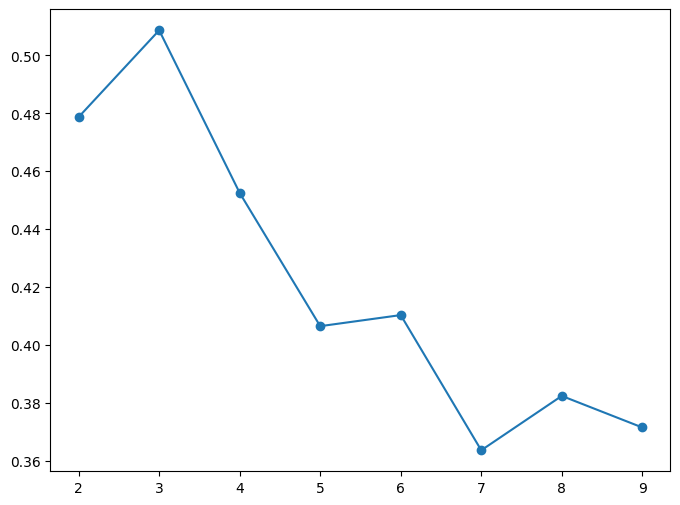

In [49]:
# K-means
X = clusterIncome.loc[:, ['gdpppp', 'gini']].values
Y = clusterIncome.index
display(X.shape)
display(Y.shape)
# 117 pays
clusterIncome.index
# réduction des données 
scale = preprocessing.StandardScaler().fit(X)
xScaled = scale.transform(X)

#Calcul  de la métrique "silhouette" pour différents nombres de groupes issus de la méthode des centres mobiles
#Liste pour stocker nos coefficients
silhouettes = [] 

for k in range(2, 10): 
    clus = cluster.KMeans(n_clusters=k)  
    clus.fit(xScaled)
    #Stockage des coefficients associés
    silh = metrics.silhouette_score(xScaled, clus.labels_)
    silhouettes.append(silh)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

In [50]:
nbCluster = 3
clust = cluster.KMeans(n_clusters=nbCluster)
clust.fit(xScaled)
#Tableau des Centroïdes
centroids = clust.cluster_centers_
pd.DataFrame(centroids, columns=['gdpppp', 'gini'], index=['cluster1', 'cluster2','cluster3'])
# Assigne la position des cluster par pays et on en fait un df (0,1,2 selon la position du tableau)
clustIndex = np.argsort(clust.labels_)
clustDf = pd.DataFrame(clusterIncome.index[clustIndex], clust.labels_[clustIndex]).reset_index()
clustDf = clustDf.rename(columns={'index':'cluster'})
clustDf['cluster'] = clustDf['cluster'].replace({0:1, 1:2, 2:3})
clustDf

/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,cluster,country
0,1,COD
1,1,ECU
2,1,SLV
3,1,MAR
4,1,PRY
...,...,...
111,3,ESP
112,3,DNK
113,3,SVK
114,3,GRC


In [51]:
# merge dans le dataframe principal 
incomes = pd.merge(incomes, clustDf, on="country")
incomes.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome,cluster
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.3,2947314000,2994.83,2
1,ALB,7297.0,916.66235,Albania,100,2,2008,0.3,2947314000,2994.83,2
2,ALB,7297.0,1010.91600,Albania,100,3,2008,0.3,2947314000,2994.83,2
3,ALB,7297.0,1086.90780,Albania,100,4,2008,0.3,2947314000,2994.83,2
4,ALB,7297.0,1132.69970,Albania,100,5,2008,0.3,2947314000,2994.83,2


In [52]:
clusterIncome = pd.merge(clusterIncome, clustDf, on="country")
clusterIncome.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome,cluster
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.30,2947314000,2994.83,2
1,ARG,13220.0,254.08942,Argentina,100,1,2008,0.45,40080160000,5847.88,1
2,ARM,5611.0,366.61780,Armenia,100,1,2008,0.29,2907618000,1628.38,2
3,AUT,36193.0,2958.07640,Austria,100,1,2008,0.30,8321496000,16637.60,3
4,AZE,8101.0,397.53983,Azerbaijan,100,1,2008,0.31,8763400000,2357.43,2


In [53]:
clustDf.head()

,cluster,country
0,1,COD
1,1,ECU
2,1,SLV
3,1,MAR
4,1,PRY


In [55]:
premierCluster = str(len(clustDf[clustDf['cluster'] == 1]))
secondCluster = str(len(clustDf[clustDf['cluster'] == 2]))
troisiemeCluster = str(len(clustDf[clustDf['cluster'] == 3]))
print("nb cluster 1 : " + premierCluster)
print("nb cluster 2 : " + secondCluster)
print("nb cluster 3 : " + troisiemeCluster)

nb cluster 1 : 37
nb cluster 2 : 53
nb cluster 3 : 26


In [56]:
firstClusterIncome = incomes[incomes['cluster'] == 1]
firstClusterIncome.head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome,cluster
100,ARG,13220.0,254.08942,Argentina,100,1,2008,0.45,40080160000,5847.88,1


In [57]:
firstClusterIncome['income'].mean()

3069.323789704054

In [58]:
firstClusterIncome['gini'].mean()

0.4805405405405405

In [59]:
secondClusterIncome = incomes[incomes['cluster'] == 2]
secondClusterIncome.head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome,cluster
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.3,2947314000,2994.83,2


In [60]:
secondClusterIncome['income'].mean()

2998.5272692

In [61]:
thirdClusterIncome = incomes[incomes['cluster'] == 3]
thirdClusterIncome.head(1)

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome,cluster
300,AUT,36193.0,2958.0764,Austria,100,1,2008,0.3,8321496000,16637.6,3


In [62]:
thirdClusterIncome['income'].mean()

16816.677743707696

In [68]:
dfCluster1 = clusterIncome[clusterIncome['cluster'] == 1]
dfCluster1.head()

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome,cluster
1,ARG,13220.0,254.089420,Argentina,100,1,2008,0.45,40080160000,5847.88,1
11,BOL,3950.0,20.584948,Bolivia,100,1,2008,0.51,9721454000,3016.26,1
12,BRA,9559.0,144.028460,Brazil,100,1,2008,0.54,192030362000,4807.48,1
14,CAF,685.0,40.928130,Central African Republic,100,1,2008,0.56,4273366000,811.30,1
16,CHL,13390.0,231.630040,Chile,100,1,2009,0.49,16708258000,7051.61,1


In [72]:
normalizeCountry = preprocessing.scale(X)
km = cluster.KMeans(n_clusters = 10).fit(normalizeCountry)
closeCountries, _ = pairwise_distances_argmin_min(km.cluster_centers_, normalizeCountry)
closeCountries

/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([112,  20,  80,  87,  19,  62, 110,  29,  23,   0])

In [73]:
clusterRepresentationCountries = clusterIncome.iloc[closeCountries].sort_values('gdpppp', ascending=False)
# Les pays les plus aux centre du cluster 
clusterRepresentationCountries

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome,cluster
62,LUX,73127.0,5780.83740,Luxembourg,100,1,2008,0.33,488650000,25217.56,3
29,ESP,28336.0,796.71906,Spain,100,1,2008,0.34,45954106000,13116.99,3
23,CZE,23223.0,1586.24710,Czechia,100,1,2008,0.26,10384603000,8235.29,3
112,VEN,11756.0,171.89282,Venezuela,100,1,2006,0.47,27635832000,3167.15,1
110,URY,11682.0,472.62976,Uruguay,100,1,2008,0.45,3340221000,5290.78,1
20,COL,8185.0,62.60506,Colombia,100,1,2008,0.56,44254975000,3547.01,1
87,PER,7858.0,172.70412,Peru,100,1,2008,0.48,28562317000,3330.53,1
0,ALB,7297.0,728.89795,Albania,100,1,2008,0.30,2947314000,2994.83,2
19,CMR,2007.0,396.45250,Cameroon,100,1,2007,0.43,19252666000,1794.49,1
80,NGA,1946.0,51.04976,Nigeria,100,1,2010,0.47,150269623000,691.86,1


In [75]:
selectCountries = ['France', 'United States', 'China', 'India', 'Luxembourg', 'Cameroon', 'Germany', 'Australia', 'Canada', 'Japan']
incomesSelected = incomes[incomes['nation'].isin(selectCountries)]
incomesSelected

,country,gdpppp,income,nation,nb_quantiles,quantile,year,gini,population,meanIncome,cluster
1500,CAN,35895.0,122.42481,Canada,100,1,2008,0.35,33247118000,23739.64,3
1501,CAN,35895.0,1692.51420,Canada,100,2,2008,0.35,33247118000,23739.64,3
1502,CAN,35895.0,2715.05370,Canada,100,3,2008,0.35,33247118000,23739.64,3
1503,CAN,35895.0,3541.33810,Canada,100,4,2008,0.35,33247118000,23739.64,3
1504,CAN,35895.0,4237.81540,Canada,100,5,2008,0.35,33247118000,23739.64,3
...,...,...,...,...,...,...,...,...,...,...,...
11195,USA,43261.0,69926.37000,United States,100,96,2008,0.43,304093966000,25503.58,3
11196,USA,43261.0,77634.82000,United States,100,97,2008,0.43,304093966000,25503.58,3
11197,USA,43261.0,88482.84000,United States,100,98,2008,0.43,304093966000,25503.58,3
11198,USA,43261.0,106765.26000,United States,100,99,2008,0.43,304093966000,25503.58,3


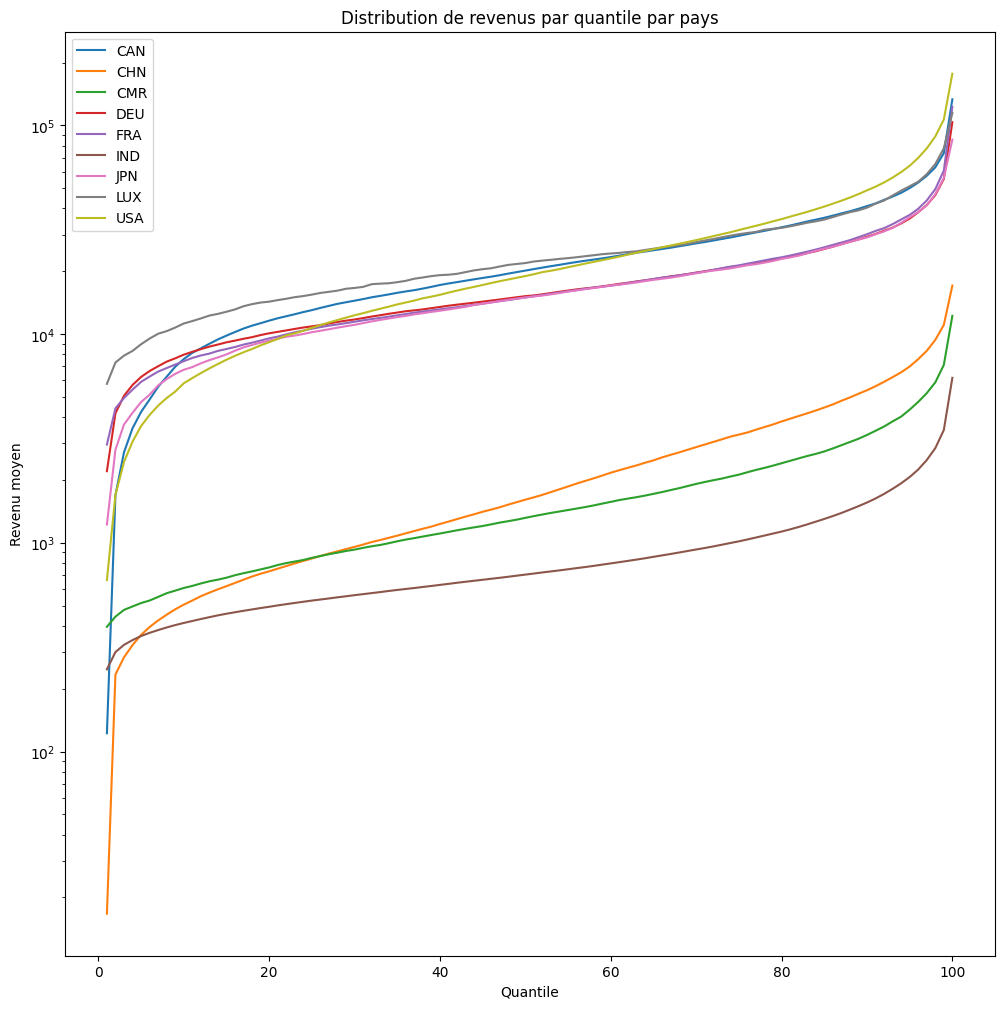

In [79]:
plt.figure(figsize=(12, 12))
sns.lineplot(x='quantile', y='income', hue='country', data=incomesSelected)
plt.yscale('log')
plt.xlabel('Quantile')
plt.ylabel('Revenu moyen')
plt.title('Distribution de revenus par quantile par pays')
plt.legend()
plt.show()

In [77]:
incomeFrench = incomes.loc[incomes.country == 'FRA', ['income', 'quantile','country','nation']]
incomeFrench

,income,quantile,country,nation
3200,2958.3040,1,FRA,France
3201,4412.6753,2,FRA,France
3202,4939.6350,3,FRA,France
3203,5422.9165,4,FRA,France
3204,5906.5376,5,FRA,France
...,...,...,...,...
3295,39873.5100,96,FRA,France
3296,43693.0350,97,FRA,France
3297,49489.5820,98,FRA,France
3298,60758.6130,99,FRA,France


# Mission 3